In [2]:
import pandas as pd
import numpy as np

In [2]:

sheet_url='https://docs.google.com/spreadsheets/d/1MvIxVRBs4u6UFfvnu2khnU_gtrcoLUch5Tci-hcdkAk/edit#gid=635530870'
csv_export_url = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')

df = pd.read_csv(csv_export_url)
df

,Sentence,Label
0,NaN,1
1,""" or pg_sleep ( __TIME__ ) --",1
2,create user name identified by pass123 tempora...,1
3,%29,1
4,AND 1 = utl_inaddr.get_host_address ( ( SE...,1
...,...,...
37939,"org/?option = com_k2 <a href = ""http://corfopym",0
37940,com/?option = com_k2 <act> <![CDATA[procMemb...,0
37941,picsearch,0
37942,com/is?-WZx-uhyLezKNiYLvAbKL3W4oh5F749nr2KUmFF...,0


In [3]:
df.dtypes

Sentence    object
Label        int64
dtype: object

In [4]:
sentence_col = df.drop(['Label'],axis='columns')
Y = df['Label']
sentence_col

,Sentence
0,NaN
1,""" or pg_sleep ( __TIME__ ) --"
2,create user name identified by pass123 tempora...
3,%29
4,AND 1 = utl_inaddr.get_host_address ( ( SE...
...,...
37939,"org/?option = com_k2 <a href = ""http://corfopym"
37940,com/?option = com_k2 <act> <![CDATA[procMemb...
37941,picsearch
37942,com/is?-WZx-uhyLezKNiYLvAbKL3W4oh5F749nr2KUmFF...


# Pre Processing

1) removed \n at the end of each line

2) replaced %20 by space #### Source: https://github.com/foospidy/payloads/tree/master/other/sqli

In [5]:
# preprocess sql data to have same format for all files

def clean_sqli_data(data):
    
    for i in range(len(data)):
        
        data[i]=data[i].replace('\n', '')
        data[i]=data[i].replace('%20', ' ')
        data[i]=data[i].replace('=', ' = ')
        data[i]=data[i].replace('((', ' (( ')
        data[i]=data[i].replace('))', ' )) ')
        data[i]=data[i].replace('(', ' ( ')
        data[i]=data[i].replace(')', ' ) ')
    
    return data

In [6]:

# removing the row if "Sentence" column contains null  value
df.dropna(subset = ["Sentence"], inplace=True)


sql_lines=[]
labels=[]
# inserting dataframe data into list
for index, row in df.iterrows():
    sql_lines.append(row['Sentence'] )
    labels.append(row['Label'])
    #print(type(row['Sentence']))
    #print(row['Sentence'])


cleaned_data=clean_sqli_data(sql_lines)
cleaned_df = pd.DataFrame(list(zip(cleaned_data, labels)),columns =['Query', 'Label'])
cleaned_df

,Query,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,%29,1
3,AND 1 = utl_inaddr.get_host_address ( ...,1
4,select * from users where id = '1' or @ @1 ...,1
...,...,...
37919,"org/?option = com_k2 <a href = ""http://co...",0
37920,com/?option = com_k2 <act> <![CDATA[procMe...,0
37921,picsearch,0
37922,com/is?-WZx-uhyLezKNiYLvAbKL3W4oh5F749nr2KUmFF...,0


# **Feature Extraction**

In [7]:
#  Detect select/update/insert/delete keyword at the initial part of the query

def isFetchCommandType(query):

    intial_keyword = query.split(' ')[0].lower()
    if( intial_keyword == 'select' ):
        return 1
    else:
        return 0

def isUpdateCommandType(query):
    intial_keyword = query.split(' ')[0].lower()
    if( intial_keyword == 'update' ):
        return 1
    else:
        return 0
      
def isInsertCommandType(query):
    intial_keyword = query.split(' ')[0].lower()
    if( intial_keyword == 'insert' ):
        return 1
    else:
        return 0

def isDeleteCommandType(query):
    intial_keyword = query.split(' ')[0].lower()
    if( intial_keyword == 'delete' ):
        return 1
    else:
        return 0


print(isFetchCommandType("INSERT into(223,'sajid','2343113')") )
print(isUpdateCommandType("DELETE into(223,'brishty','2343113')") )
print(isInsertCommandType("DELETE into(223,'sajid','2343113')") )
print(isDeleteCommandType("DELETE into(223,'brishty','2343113')") )

0
0
0
1


In [8]:
# Detect 'order by' keyword in the query

def detectSortClause(query):
    keyword='order by'
    if(keyword in query.lower()):
        return 1
    else:
        return 0
    
print(detectSortClause("-5021'+ ( select yadq where 4285 = 4285 Order By 1#"))

1


In [9]:
  # Detect group by keyword
  def detectGroupClause(query):
      keyword= 'group by'  
      if(keyword in query.lower()):
          return 1
      else:
          return 0

print(detectGroupClause("-5021'+ ( select yadq where 4285 = 4285 Group By 1#"))

1


In [10]:
# Detect over keyword 

def detectWindowClause(query):
    keyword='over'
    if(keyword in query.lower()):
        return 1
    else:
        return 0

print(detectWindowClause("-5021'+ ( select yadq where 4285 = 4285 order by 1#"))

0


In [11]:
#hasRecursive: Indicator if SQL is specified WITH RECURSIVE clause
def detectWithRecursive(query):
    keyword='with recursive'
    if(keyword in query.lower()):
        return 1
    else:
        return 0
print(detectWithRecursive('With Recursive parent_of(name, parent) AS (SELECT name, mom FROM family UNION SELECT name, dad FROM family);'))


1


In [12]:
#hasDistinctOn: Indicator if distinct clause is from DISTINCT ON
def detecthasDistinctOn(query):
    keyword= 'distinct on'
    if(keyword in query.lower()):
        return 1
    else:
        return 0

print(detecthasDistinctOn('SELECT * FROM (SELECT DISTINCT ON(address_id) * FROM purchases WHERE product_id = 1 ORDER BY address_id, purchased_at DESC) t ORDER BY purchased_at DESC;'))
print(detecthasDistinctOn('SELECT * FROM First JOIN SELECT * FROM Second;')  )


1
0


In [13]:
#utilityStmt: Indicator if the SQL is DECLARE CURSOR or a non-optimizable statement

def utilityStmt(query):
    keyword1='declare'
    keyword2='cursor'
    if(keyword1 in query.lower() and keyword2 in query.lower()):
      return 1
    else:
      return 0

print(utilityStmt('EXEC SQL DECLARE C3 CURSOR WITH HOLD FOR SELECT * FROM EMPLOYEE FOR UPDATE OF WORKDEPT, PHONENO, JOB, EDLEVEL, SALARY;'))
print(utilityStmt('SELECT * FROM First JOIN SELECT * FROM Second;')  )


1
0


operators list in this link: https://www.w3schools.com/sql/sql_operators.asp

In [14]:
#jointree/quals/args*/boolop* : Qualification type BOOLEXPR, OPEXPR and boolean operation and, or, not

def hasLogicalOperator(query):
      keywords=['and','or','not','all','any','between','exists','in','like','some']
      for key in keywords:
        if(key in query.lower()):
          return 1
        else:
          return 0

print(hasLogicalOperator('SELECT column-names FROM table-name WHERE condition1 AND condition2;'))
print(hasLogicalOperator('UPDATE table-name SET column-name = value WHERE condition1 OR condition2;'))
print(hasLogicalOperator('DELETE table-name WHERE NOT condition;'))

1
0
0


In [15]:


def hasArithmaticOperator(query):
    keywords=['+','-','*','/','%']
   
    for key in keywords:
        if(key in query):
            return 1
        
    return 0


print(hasArithmaticOperator("SELECT city, SUM(order_amount) total_order_amount FROM sum GROUP BY city"))

0


In [16]:

def hasComparisonOperator(query):
    keywords=['=','>','<','>=','<=','<>']
    
    for key in keywords:
        if(key in query):
            return 1
        
    return 0

print(hasComparisonOperator('SELECT * FROM Products WHERE Price = 18;' ) )

1


In [17]:

def hasCompoundOperator(query):
    keywords=['+=','-=',"*=",'/=','%=','&=','^-=','|*=']
   
    for key in keywords:
        if(key in query):
            return 1
    return 0


print(hasCompoundOperator('SELECT * FROM Products WHERE Price = 18;' ))

0


**List of window functions**: https://www.sqlshack.com/use-window-functions-sql-server/

In [18]:
# detect window function in the query RANK(), DENSE_RANK(), ROW_NUMBER(), NTILE(),SUM(), MAX(), MIN(), AVG(). COUNT(),LAG(), LEAD(), FIRST_VALUE(), LAST_VALUE(),
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

def hasWindowFunc(query):
    window_func_list=['sum','avg','max','min','count','rank','dense_rank','row_number','nitle','lag','lead','first_value','last_value']
    tokenized_list = word_tokenize(query.lower())
   
    #print(tokenized_list)
    for window_func in window_func_list:
        #print(window_func)
        for i in range(len(tokenized_list)):
            if(window_func == tokenized_list[i]):
                if(i+1 < len(tokenized_list)):
                      if( tokenized_list[i+1] == '('):
                          return 1
                      else:
                          return 0
    return 0



hasWindowFunc("SELECT city, SUM(order_amount) total_order_amount FROM sum GROUP BY city")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


1

In [19]:
# hasAggs: Indicator if SQL has aggregates (sum(),avg(),max(),min(),count())
def hasAggs(query):
    Agg_func_list=['sum','avg','max','min','count']
    tokenized_list = word_tokenize(query.lower())
    
    #print(tokenized_list)
    for Agg_func in Agg_func_list:
        #print(window_func)
        for i in range(len(tokenized_list)):
            if(Agg_func == tokenized_list[i]):
                if( tokenized_list[i+1] == '('):
                    return 1
                else:
                    return 0
    return 0

    
print(hasAggs("-5021'+ avg( select yadq where 4285 = 4285 order by 1#"))
print(utilityStmt('SELECT * FROM First JOIN SELECT * FROM Second;')  )
print(hasAggs("-5021'+ max( select yadq where 4285 = 4285 order by 1#"))
print(hasAggs("-5021'+ min( select yadq where 4285 = 4285 order by 1#"))
print(hasAggs("-5021'+ count( select yadq where 4285 = 4285 order by 1#"))

1
0
1
1
1


In [20]:
#detect set operations like union,union all, except, intersect

def hasSetOperation(query):
    set_list=['union','union all','except','intersect']
    tokenized_list = word_tokenize(query.lower())
   
    #print(tokenized_list)
    for set_op in set_list:
        #print(window_func)
        for i in range(len(tokenized_list)):
            if(set_op in tokenized_list):
                return 1
            
    return 0

print(hasSetOperation('SELECT * FROM First JOIN SELECT * FROM Second;'))

0


In [21]:
#cteList---> getNumberOfWithClause() 
# detect number of with clasue 

def getNumberOfWithClause(query) :
    keyword='with'
    
    tokenized_list = word_tokenize(query.lower())
    print(tokenized_list)
    cnt=0
    for word in tokenized_list:
        if(keyword == word ):
            cnt +=1
    
    return cnt    




print(getNumberOfWithClause( ' WITH totalSalary(Airline, total) as (SELECT Airline, sum(Salary) FROM Pilot GROUP BY Airline),airlineAverage(avgSalary) as (SELECT avg(Salary) FROM Pilot )  SELECT Airline FROM totalSalary, airlineAverage WHERE totalSalary.total >= airlineAverage.avgSalary;'))

['with', 'totalsalary', '(', 'airline', ',', 'total', ')', 'as', '(', 'select', 'airline', ',', 'sum', '(', 'salary', ')', 'from', 'pilot', 'group', 'by', 'airline', ')', ',', 'airlineaverage', '(', 'avgsalary', ')', 'as', '(', 'select', 'avg', '(', 'salary', ')', 'from', 'pilot', ')', 'select', 'airline', 'from', 'totalsalary', ',', 'airlineaverage', 'where', 'totalsalary.total', '>', '=', 'airlineaverage.avgsalary', ';']
1


In [22]:
# detect sub query in the query

def detectSubQuery(query):
    commands = ['select','update','insert','delete']
    tokenized_list = word_tokenize(query.lower())
    cnt=0
    for command in commands:
        if(command in tokenized_list):
            cnt+=1
    if(cnt>1):
        return 1
    else:
        return 0


print(detectSubQuery('UPDATE CUSTOMERS SET SALARY = SALARY * 0.25 WHERE AGE IN ( SELECT AGE FROM CUSTOMERS_BKP WHERE AGE >= 27 );'))

print( detectSubQuery('INSERT INTO CUSTOMERS_BKP SELECT * FROM CUSTOMERS WHERE ID IN (SELECT ID FROM CUSTOMERS) ;') )

1
1


In [23]:
# detect string constant type 


def hasStringConstnt(query):
    ck=0
    new_query=query.lower()
    
    for i in range(len(new_query)):
        
        if(new_query[i] == '\''):
            ck=1
            break
            
    if(ck==1 ):
        return 1
    else:
        return 0

print(hasStringConstnt("SELECT * FROM Customers WHERE Country='Mexico' and city='\t';") )

1


Constants:  https://ecomputernotes.com/what-is-c/types-and-variables/what-is-constants-type-of-constant

In [24]:
# detect backslash character constants

def hasEscapeSeq(query):
    escape_chars=['\a',
                  '\b',
                  '\f',
                  '\n',
                  '\r',
                  '\t',
                  '\v',
                  '\'',
                  "\''",
                  '\?',
                  '\\',
                  '\0']
    for chars in escape_chars:
        if(chars in  query.lower()):
            return 1
        
    return 0    


print(hasEscapeSeq("SELECT * FROM Customers WHERE Country='Mexico' and city='';") )


1


In [25]:
# detect numbers in query
from sklearn.feature_extraction.text import CountVectorizer

def detectNumber(query):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform([query])
    print(vectorizer.get_feature_names())
    tokenized_list=vectorizer.get_feature_names()
    for word in tokenized_list:
        ck=0
        try:
          num = int(word)
          ck=1 
        except:
          try:
            num = float(word)
            ck=2
          except:
            ck=3
        if(ck == 1 or ck == 2):
          return 1 #number
        else:
          return 0 #non-number
        
      
    


print(detectNumber("SELECT * FROM Customers WHERE AGE==20 "))

['20', 'age', 'customers', 'from', 'select', 'where']
1


# Encapsulation of feature extraction functions inside a class

In [26]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

class SqlFeatureExtraction:

    def __init__(self):
        print("SQL feature extraction object created")

    def extractFeatures(self,query):
        features=[]
        features.append( isFetchCommandType(query) )
        features.append( isUpdateCommandType(query) )
        features.append( isInsertCommandType(query) )
        features.append( isDeleteCommandType(query) )
        features.append( detectSortClause(query) )
        features.append( detectGroupClause(query) )
        features.append( detectWindowClause(query) )
        features.append( detectWithRecursive(query) )
        features.append( detecthasDistinctOn(query) )
        features.append( utilityStmt(query) )
        features.append(hasLogicalOperator(query) )
        features.append( hasArithmaticOperator(query)  )
        features.append( hasComparisonOperator(query)  )
        features.append( hasCompoundOperator(query) )
        features.append( hasWindowFunc(query) )
        features.append( hasAggs(query)  )
        features.append( hasSetOperation(query) )  
        features.append(getNumberOfWithClause(query))
        features.append( detectSubQuery(query) )
        features.append( hasStringConstnt(query) )
        features.append( hasEscapeSeq(query) )
        features.append( detectNumber(query) )
        return features
    
    #  Detect select/update/insert/delete keyword at the initial part of the query
    # f1
    def isFetchCommandType(query):

        intial_keyword = query.split(' ')[0].lower()
        if( intial_keyword == 'select' ):
            return 1
        else:
            return 0

    #f2
    def isUpdateCommandType(query):
        intial_keyword = query.split(' ')[0].lower()
        if( intial_keyword == 'update' ):
            return 1
        else:
            return 0
    #f3   
    def isInsertCommandType(query):
        intial_keyword = query.split(' ')[0].lower()
        if( intial_keyword == 'insert' ):
            return 1
        else:
            return 0
    #f4
    def isDeleteCommandType(query):
        intial_keyword = query.split(' ')[0].lower()
        if( intial_keyword == 'delete' ):
            return 1
        else:
            return 0


    # Detect 'order by' keyword in the query
    #f5
    def detectSortClause(query):
        keyword='order by'
        if(keyword in query.lower()):
            return 1
        else:
            return 0

    # Detect group by keyword
    def detectGroupClause(query):
          keyword= 'group by'  
          if(keyword in query.lower()):
              return 1
          else:
              return 0


    # Detect over keyword 

    def detectWindowClause(query):
        keyword='over'
        if(keyword in query.lower()):
            return 1
        else:
            return 0


    #hasRecursive: Indicator if SQL is specified WITH RECURSIVE clause
    def detectWithRecursive(query):
        keyword='with recursive'
        if(keyword in query.lower()):
            return 1
        else:
            return 0


    #hasDistinctOn: Indicator if distinct clause is from DISTINCT ON
    def detecthasDistinctOn(query):
        keyword= 'distinct on'
        if(keyword in query.lower()):
            return 1
        else:
            return 0

    #utilityStmt: Indicator if the SQL is DECLARE CURSOR or a non-optimizable statement

    def utilityStmt(query):
        keyword1='declare'
        keyword2='cursor'
        if(keyword1 in query.lower() and keyword2 in query.lower()):
          return 1
        else:
          return 0

    #jointree/quals/args*/boolop* : Qualification type BOOLEXPR, OPEXPR and boolean operation and, or, not

    def hasLogicalOperator(query):
          keywords=['and','or','not','all','any','between','exists','in','like','some']
          for key in keywords:
            if(key in query.lower()):
              return 1
            else:
              return 0

    def hasArithmaticOperator(query):
        keywords=['+','-','*','/','%']
      
        for key in keywords:
            if(key in query):
                return 1
            
        return 0

    def hasComparisonOperator(query):
        keywords=['=','>','<','>=','<=','<>']
        
        for key in keywords:
            if(key in query):
                return 1
            
        return 0


    def hasCompoundOperator(query):
        keywords=['+=','-=',"*=",'/=','%=','&=','^-=','|*=']
      
        for key in keywords:
            if(key in query):
                return 1
        return 0



    # detect window function in the query RANK(), DENSE_RANK(), ROW_NUMBER(), NTILE(),SUM(), MAX(), MIN(), AVG(). COUNT(),LAG(), LEAD(), FIRST_VALUE(), LAST_VALUE(),


    def hasWindowFunc(query):
        window_func_list=['sum','avg','max','min','count','rank','dense_rank','row_number','nitle','lag','lead','first_value','last_value']
        tokenized_list = word_tokenize(query.lower())
      
        #print(tokenized_list)
        for window_func in window_func_list:
            #print(window_func)
            for i in range(len(tokenized_list)):
                if(window_func == tokenized_list[i]):
                    if(i+1 < len(tokenized_list)):
                        if( tokenized_list[i+1] == '('):
                            return 1
                        else:
                            return 0
        return 0


    # hasAggs: Indicator if SQL has aggregates (sum(),avg(),max(),min(),count())
    def hasAggs(query):
        Agg_func_list=['sum','avg','max','min','count']
        tokenized_list = word_tokenize(query.lower())
        
        #print(tokenized_list)
        for Agg_func in Agg_func_list:
            #print(window_func)
            for i in range(len(tokenized_list)):
                if(Agg_func == tokenized_list[i]):
                    if( tokenized_list[i+1] == '('):
                        return 1
                    else:
                        return 0
        return 0


    #detect set operations like union,union all, except, intersect

    def hasSetOperation(query):
        set_list=['union','union all','except','intersect']
        tokenized_list = word_tokenize(query.lower())
      
        #print(tokenized_list)
        for set_op in set_list:
            #print(window_func)
            for i in range(len(tokenized_list)):
                if(set_op in tokenized_list):
                    return 1
                
        return 0


    #cteList---> getNumberOfWithClause() 
    # detect number of with clasue 

    def getNumberOfWithClause(query) :
        keyword='with'
        
        tokenized_list = word_tokenize(query.lower())
        #print(tokenized_list)
        cnt=0
        for word in tokenized_list:
            if(keyword == word ):
                cnt +=1
        
        return cnt



    # detect sub query in the query

    def detectSubQuery(query):
        commands = ['select','update','insert','delete']
        tokenized_list = word_tokenize(query.lower())
        cnt=0
        for command in commands:
            if(command in tokenized_list):
                cnt+=1
        if(cnt>1):
            return 1
        else:
            return 0


    # detect string constant type 

    def hasStringConstnt(query):
        ck=0
        new_query=query.lower()
        
        for i in range(len(new_query)):
            
            if(new_query[i] == '\''):
                ck=1
                break
                
        if(ck==1 ):
            return 1
        else:
            return 0



    # detect backslash character constants

    def hasEscapeSeq(query):
        escape_chars=['\a',
                      '\b',
                      '\f',
                      '\n',
                      '\r',
                      '\t',
                      '\v',
                      '\'',
                      "\''",
                      '\?',
                      '\\',
                      '\0']
        for chars in escape_chars:
            if(chars in  query.lower()):
                return 1
            
        return 0    


    # detect numbers in query


    def detectNumber(query):
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform([query])
        #print(vectorizer.get_feature_names())
        tokenized_list=vectorizer.get_feature_names()
        for word in tokenized_list:
            ck=0
            try:
              num = int(word)
              ck=1 
            except:
              try:
                num = float(word)
                ck=2
              except:
                ck=3
            if(ck == 1 or ck == 2):
              return 1 #number
            else:
              return 0 #non-number
            
      








[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [27]:
column_names=['FetchCommandType','UpdateCommandType','InsertCommandType',
             'DeleteCommandType','detectSortClause','detectGroupByClause',
             'detectWindowClause','detectWithRecursive','detectDistinctOn',
             'detectDeclareCursor','detectLogicalOperator',
             'detectArithmaticOperator','detectComparisonOperator','hasCompoundOperator',
             'detectWindowFunc','detectAggregates','detectSetOperation',
             'detectNumberOfWithClause','detectSubQuery',
             'detectStringConstant','detectBackslash','detectNumber','Label']

len(column_names)

23

In [28]:


feature_val_list=[]



for index, row in cleaned_df.iterrows():
    obj = SqlFeatureExtraction()
    try:
      feature_val = obj.extractFeatures(row['Query'])
      feature_val.append(row['Label'])
      feature_val_list.append(feature_val)
    except ValueError:
      print("value Error: "+str(ValueError.args))


feature_table = pd.DataFrame(feature_val_list,columns=column_names)



Streaming output truncated to the last 5000 lines.
['athletes', 'assistants', 'seemed', 'satisfied', 'smooth', 'well-organised', 'running', 'event']
['assistants', 'athletes', 'event', 'organised', 'running', 'satisfied', 'seemed', 'smooth', 'well']
SQL feature extraction object created
['rbs', 'suspends', 'two', 'forex', 'traders', 'royal', 'bank', 'scotland', 'suspended', 'two', 'traders', 'foreign', 'exchange', 'division', 'according', 'two', 'people', 'familiar', 'situation', ',', 'another', 'sign', 'global', 'probe', 'regulators', 'suspected', 'manipulation', 'currency', 'market', 'rapidly', 'gaining', 'traction']
['according', 'another', 'bank', 'currency', 'division', 'exchange', 'familiar', 'foreign', 'forex', 'gaining', 'global', 'manipulation', 'market', 'people', 'probe', 'rapidly', 'rbs', 'regulators', 'royal', 'scotland', 'sign', 'situation', 'suspected', 'suspended', 'suspends', 'traction', 'traders', 'two']
SQL feature extraction object created
['some', 'world', '&', 'ap

# Write feature table to CSV

In [29]:
feature_table.to_csv("sql_preprocessed_table.csv")

In [6]:
sheet_url='https://docs.google.com/spreadsheets/d/1B5wyGQ1zeGfNVhmaon05mmDnazgoVmNcQlmQg-C6kmU/edit#gid=1153274005'
csv_export_url = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')

feature_table = pd.read_csv(csv_export_url)
feature_table

,FetchCommandType,UpdateCommandType,InsertCommandType,DeleteCommandType,detectSortClause,detectGroupByClause,detectWindowClause,detectWithRecursive,detectDistinctOn,detectDeclareCursor,detectLogicalOperator,detectArithmaticOperator,detectComparisonOperator,hasCompoundOperator,detectWindowFunc,detectAggregates,detectSetOperation,detectNumberOfWithClause,detectSubQuery,detectStringConstant,detectBackslash,detectNumber,Label
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,1
4,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37704,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
37705,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0
37706,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
37707,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0


## Visualization

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
feature_table.mean()

FetchCommandType            0.022780
UpdateCommandType           0.000080
InsertCommandType           0.000186
DeleteCommandType           0.000080
detectSortClause            0.004959
detectGroupByClause         0.007399
detectWindowClause          0.009892
detectWithRecursive         0.000000
detectDistinctOn            0.000000
detectDeclareCursor         0.000000
detectLogicalOperator       0.158556
detectArithmaticOperator    0.309369
detectComparisonOperator    0.265905
hasCompoundOperator         0.000000
detectWindowFunc            0.042377
detectAggregates            0.042377
detectSetOperation          0.066509
detectNumberOfWithClause    0.001167
detectSubQuery              0.000000
detectStringConstant        0.150442
detectBackslash             0.153438
detectNumber                0.396457
Label                       0.329576
dtype: float64

In [33]:
feature_table.describe()

,FetchCommandType,UpdateCommandType,InsertCommandType,DeleteCommandType,detectSortClause,detectGroupByClause,detectWindowClause,detectWithRecursive,detectDistinctOn,detectDeclareCursor,detectLogicalOperator,detectArithmaticOperator,detectComparisonOperator,hasCompoundOperator,detectWindowFunc,detectAggregates,detectSetOperation,detectNumberOfWithClause,detectSubQuery,detectStringConstant,detectBackslash,detectNumber,Label
count,37709.000000,37709.000000,37709.000000,37709.000000,37709.000000,37709.000000,37709.000000,37709.0,37709.0,37709.0,37709.000000,37709.000000,37709.000000,37709.0,37709.000000,37709.000000,37709.000000,37709.000000,37709.0,37709.000000,37709.000000,37709.000000,37709.000000
mean,0.022780,0.000080,0.000186,0.000080,0.004959,0.007399,0.009892,0.0,0.0,0.0,0.158556,0.309369,0.265905,0.0,0.042377,0.042377,0.066509,0.001167,0.0,0.150442,0.153438,0.396457,0.329576
std,0.149202,0.008919,0.013624,0.008919,0.070246,0.085698,0.098964,0.0,0.0,0.0,0.365267,0.462240,0.441820,0.0,0.201451,0.201451,0.249174,0.034139,0.0,0.357508,0.360414,0.489168,0.470066
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


In [34]:
feature_table.groupby('FetchCommandType').count()

,UpdateCommandType,InsertCommandType,DeleteCommandType,detectSortClause,detectGroupByClause,detectWindowClause,detectWithRecursive,detectDistinctOn,detectDeclareCursor,detectLogicalOperator,detectArithmaticOperator,detectComparisonOperator,hasCompoundOperator,detectWindowFunc,detectAggregates,detectSetOperation,detectNumberOfWithClause,detectSubQuery,detectStringConstant,detectBackslash,detectNumber,Label
FetchCommandType,,,,,,,,,,,,,,,,,,,,,,
0,36850,36850,36850,36850,36850,36850,36850,36850,36850,36850,36850,36850,36850,36850,36850,36850,36850,36850,36850,36850,36850,36850
1,859,859,859,859,859,859,859,859,859,859,859,859,859,859,859,859,859,859,859,859,859,859


In [35]:
feature_table.groupby('FetchCommandType').mean()

,UpdateCommandType,InsertCommandType,DeleteCommandType,detectSortClause,detectGroupByClause,detectWindowClause,detectWithRecursive,detectDistinctOn,detectDeclareCursor,detectLogicalOperator,detectArithmaticOperator,detectComparisonOperator,hasCompoundOperator,detectWindowFunc,detectAggregates,detectSetOperation,detectNumberOfWithClause,detectSubQuery,detectStringConstant,detectBackslash,detectNumber,Label
FetchCommandType,,,,,,,,,,,,,,,,,,,,,,
0,0.000081,0.00019,0.000081,0.005075,0.007571,0.010122,0.0,0.0,0.0,0.153134,0.296934,0.253379,0.0,0.038209,0.038209,0.06806,0.001194,0.0,0.147001,0.148982,0.393976,0.313948
1,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.391153,0.842841,0.803260,0.0,0.221187,0.221187,0.00000,0.000000,0.0,0.298021,0.344587,0.502910,1.000000


**Spliting the dataframe** 

In [7]:
X = feature_table.drop(['Label'],axis='columns')
Y = feature_table['Label']

In [37]:
X

,FetchCommandType,UpdateCommandType,InsertCommandType,DeleteCommandType,detectSortClause,detectGroupByClause,detectWindowClause,detectWithRecursive,detectDistinctOn,detectDeclareCursor,detectLogicalOperator,detectArithmaticOperator,detectComparisonOperator,hasCompoundOperator,detectWindowFunc,detectAggregates,detectSetOperation,detectNumberOfWithClause,detectSubQuery,detectStringConstant,detectBackslash,detectNumber
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0
4,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37704,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
37705,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1
37706,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
37707,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0


**Frequency distributions of the features(Histograms)**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e874156d0>,
      dtype=object)

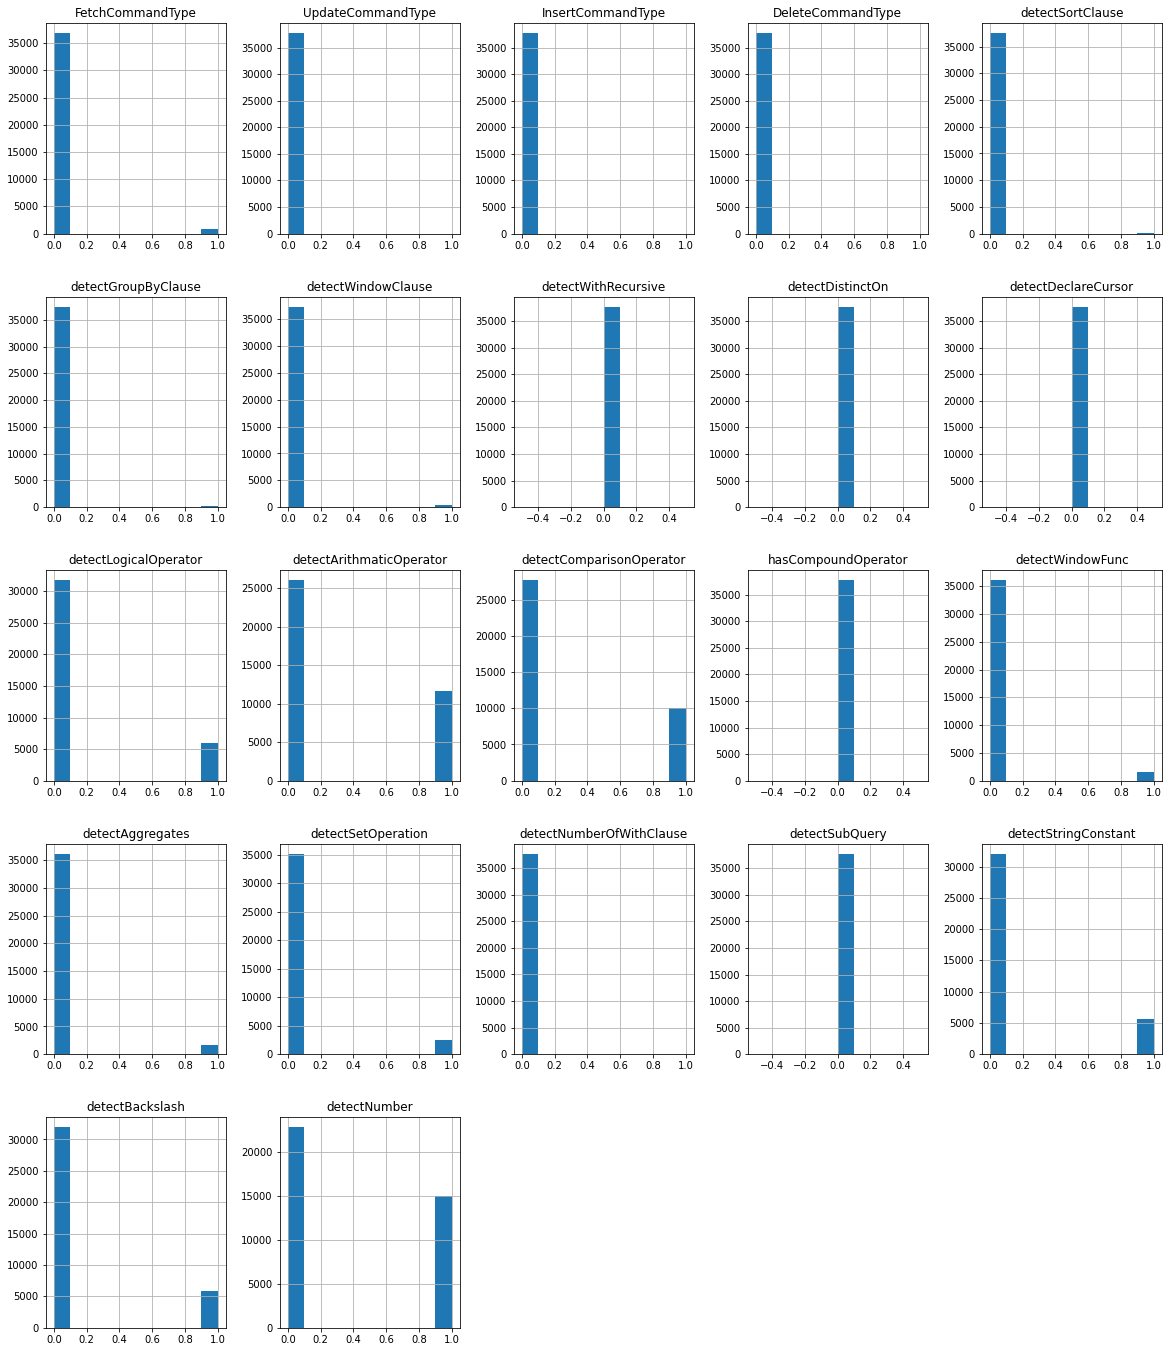

In [38]:
X.hist( figsize=(20, 24))

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/misc.py:80: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/misc.py:81: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/misc.py:71: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


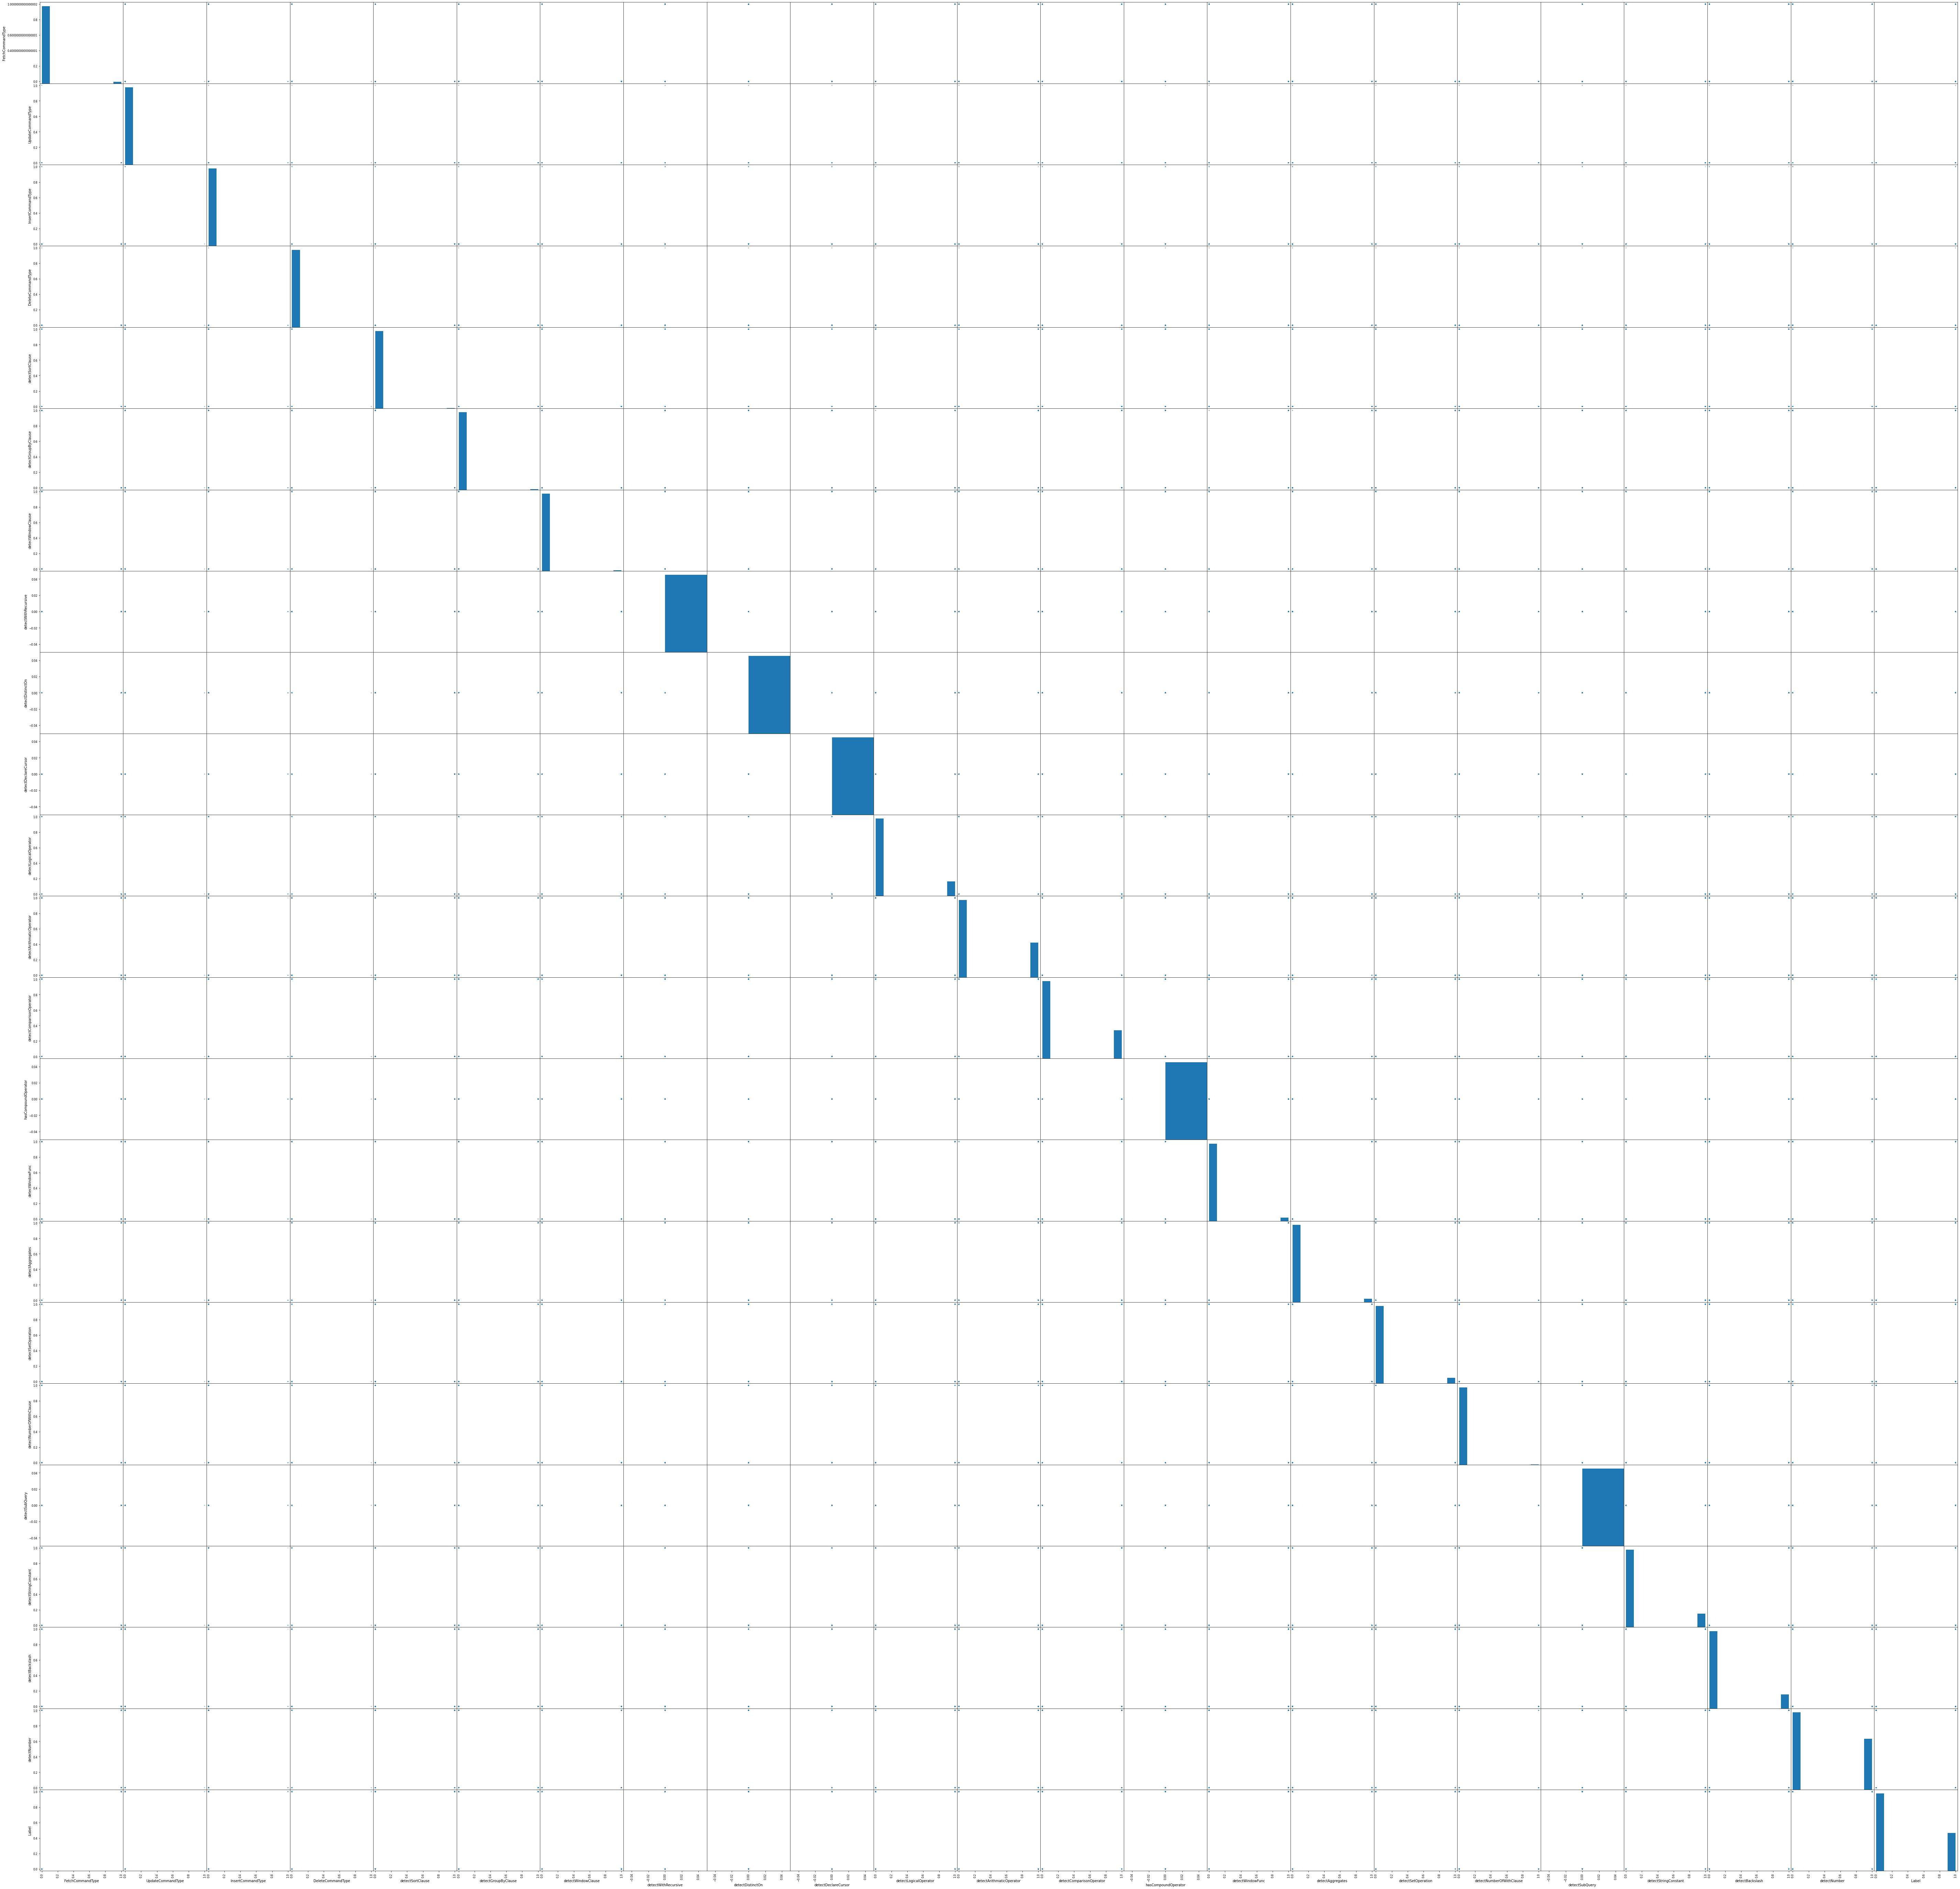

In [39]:
pd.plotting.scatter_matrix(feature_table, alpha=0.2, figsize=(100, 100))
plt.show()

[Correlation Matrix](https://heartbeat.fritz.ai/seaborn-heatmaps-13-ways-to-customize-correlation-matrix-visualizations-f1c49c816f07)

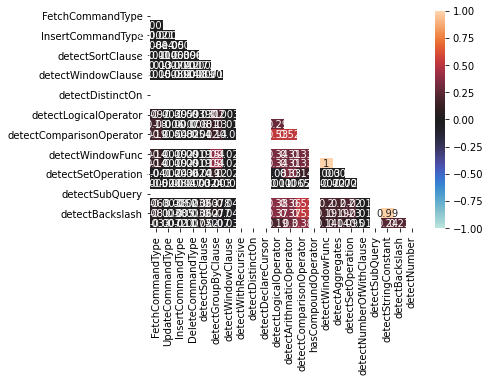

In [8]:
matrix = np.triu(X.corr())
sns.heatmap(X.corr(), annot = True,vmin=-1, vmax=1, center= 0,mask=matrix)
plt.show()

In [41]:
Y

0        1
1        1
2        1
3        1
4        1
        ..
37704    0
37705    0
37706    0
37707    0
37708    0
Name: Label, Length: 37709, dtype: int64

**Imbalanced dataset**

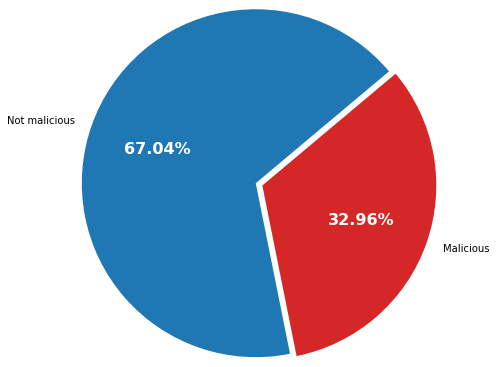

In [42]:
explode1 = (0, 0.08)
exp_labels=["Not malicious","Malicious"]
fig1, ax1 = plt.subplots()
_, _, autopcts = ax1.pie(Y.value_counts(),explode= explode1, labels=exp_labels,autopct='%0.2f%%',radius=2,
        shadow=False,startangle=40, colors=('tab:blue', 'tab:red'))

plt.setp(autopcts, **{'color':'white', 'weight':'bold', 'fontsize':16})
plt.show()

## Installing Pycaret and sklearn-genetic

In [43]:
#pip install pycaret

In [44]:
#pip install sklearn-genetic

## Feature Selection using Genetic algorithm(PyCaret)

In [45]:
'''
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from genetic_selection import GeneticSelectionCV

mcc = make_scorer(matthews_corrcoef)
estimator = LogisticRegression(solver = "liblinear", C = 6, tol = 1, fit_intercept = True)

from sklearn.model_selection import *
report = pd.DataFrame()
nofeats = [] 
chosen_feats = [] 
cvscore = [] 
rkf = RepeatedStratifiedKFold(n_repeats = 2, n_splits = 10)
for i in range(2,22):
  
    selector = GeneticSelectionCV(estimator,
                                cv = rkf,
                                verbose = 0,
                                scoring = mcc,
                                max_features = i,
                                n_population = 50,
                                crossover_proba = 0.5,
                                mutation_proba = 0.2,
                                n_generations = 10,
                                crossover_independent_proba=0.5,
                                mutation_independent_proba=0.05,
                                #tournament_size = 3,
                                n_gen_no_change=10,
                                caching=True,
                                n_jobs=-1)
  
    selector = selector.fit(X, Y)
    genfeats = X.columns[selector.support_]
    genfeats = list(genfeats)
    print("Chosen Feats:  ", genfeats)

cv_score = selector.generation_scores_[-1]
nofeats.append(len(genfeats)) 
chosen_feats.append(genfeats) 
cvscore.append(cv_score)





report["No of Feats"] = nofeats
report["Chosen Feats"] = chosen_feats
report["Scores"] = cvscore



'''


'\nfrom sklearn.metrics import *\nfrom sklearn.linear_model import LogisticRegression\nfrom genetic_selection import GeneticSelectionCV\n\nmcc = make_scorer(matthews_corrcoef)\nestimator = LogisticRegression(solver = "liblinear", C = 6, tol = 1, fit_intercept = True)\n\nfrom sklearn.model_selection import *\nreport = pd.DataFrame()\nnofeats = [] \nchosen_feats = [] \ncvscore = [] \nrkf = RepeatedStratifiedKFold(n_repeats = 2, n_splits = 10)\nfor i in range(2,22):\n  \n    selector = GeneticSelectionCV(estimator,\n                                cv = rkf,\n                                verbose = 0,\n                                scoring = mcc,\n                                max_features = i,\n                                n_population = 50,\n                                crossover_proba = 0.5,\n                                mutation_proba = 0.2,\n                                n_generations = 10,\n                                crossover_independent_proba=0.5,\n           

In [46]:
'''
report["Scores"] = np.round(report["Scores"], 3)
report.sort_values(by = "Scores", ascending = False, inplace = False)
#report.index
ga_feats = report.iloc[0]["Chosen Feats"]

used_feats =  ga_feats.copy()
used_feats.append('ClassLabel')

print(report)
print(ga_feats)
'''

'\nreport["Scores"] = np.round(report["Scores"], 3)\nreport.sort_values(by = "Scores", ascending = False, inplace = False)\n#report.index\nga_feats = report.iloc[0]["Chosen Feats"]\n\nused_feats =  ga_feats.copy()\nused_feats.append(\'ClassLabel\')\n\nprint(report)\nprint(ga_feats)\n'

## PCA Visualization

---


As we've noticed before it is difficult to visualize high dimensional data, we can use PCA to find the first two principal components, and visualize the data in this new, two-dimensional space, with a single scatter-plot. Before we do this though, we'll need to scale our data so that each feature has a single unit variance.

In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [48]:
# Standardizing the features
X = StandardScaler().fit_transform(X)
X.shape

(37709, 22)

PCA with Scikit Learn uses a very similar process to other preprocessing functions that come with SciKit Learn. We instantiate a PCA object, find the principal components using the fit method, then apply the rotation and dimensionality reduction by calling transform().

We can also specify how many components we want to keep when creating the PCA object.

In [49]:

n=18
pca = PCA(n_components=n)
principalComponents = pca.fit_transform(X)
column_names=[]
for i in range(1,n+1,1):
    column_names.append("principle component-"+str(i) )

principalDf = pd.DataFrame(data = principalComponents, columns =column_names)
principalDf

,principle component-1,principle component-2,principle component-3,principle component-4,principle component-5,principle component-6,principle component-7,principle component-8,principle component-9,principle component-10,principle component-11,principle component-12,principle component-13,principle component-14,principle component-15,principle component-16,principle component-17,principle component-18
0,-0.579625,0.180329,0.399800,-0.483503,-0.107789,0.009144,0.019496,-0.047342,-7.146933e-15,0.172389,-0.342310,0.337568,-1.051906,1.166442,0.707699,-0.007649,2.118324e-15,1.047248e-15
1,-1.305211,0.372074,0.097156,0.387664,0.016207,0.085145,0.048589,0.003125,-9.233260e-15,-0.214791,-0.341192,-0.120529,-0.148105,-0.023548,-0.098101,-0.003924,2.702449e-18,9.370788e-20
2,-0.143133,-0.166449,0.025036,-1.331444,0.049934,-0.050760,-0.037461,-0.031937,-6.151582e-15,0.194912,0.881326,0.063424,0.069860,1.039007,1.066912,0.013971,6.012552e-17,-2.052842e-18
3,2.595359,-1.813883,-0.976737,2.726554,-0.051645,0.075747,-0.032302,0.108116,7.543858e-15,-0.582173,-0.664722,0.549577,-0.362045,-0.798863,-0.506191,-0.016233,-9.900981e-17,5.299003e-18
4,2.945863,-2.969305,3.043971,0.022082,-0.947245,-0.040191,0.080568,-0.012620,2.665960e-14,0.262605,-1.243274,-0.383674,-0.867972,-0.399457,-0.908409,-0.085800,-7.922341e-17,-1.033923e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37704,0.323880,-0.117238,0.021118,-0.683279,-0.276519,0.000681,0.029692,-0.033622,3.067646e-15,0.171890,-0.115941,0.996945,-1.215849,1.379428,-1.148826,-0.039368,3.570199e-17,-4.141711e-18
37705,0.760372,-0.464015,-0.353646,-1.531220,-0.118796,-0.059223,-0.027265,-0.018217,3.336214e-15,0.194413,1.107696,0.722801,-0.094083,1.251993,-0.789614,-0.017748,5.572842e-17,-4.001851e-18
37706,-1.305211,0.372074,0.097156,0.387664,0.016207,0.085145,0.048589,0.003125,-2.521674e-15,-0.214791,-0.341192,-0.120529,-0.148105,-0.023548,-0.098101,-0.003924,1.466379e-18,5.416689e-19
37707,0.323880,-0.117238,0.021118,-0.683279,-0.276519,0.000681,0.029692,-0.033622,3.067646e-15,0.171890,-0.115941,0.996945,-1.215849,1.379428,-1.148826,-0.039368,3.570199e-17,-4.141711e-18


In [50]:
finalDf = pd.concat([principalDf, df[['Label']] ], axis = 1)
finalDf

,principle component-1,principle component-2,principle component-3,principle component-4,principle component-5,principle component-6,principle component-7,principle component-8,principle component-9,principle component-10,principle component-11,principle component-12,principle component-13,principle component-14,principle component-15,principle component-16,principle component-17,principle component-18,Label
0,-0.579625,0.180329,0.399800,-0.483503,-0.107789,0.009144,0.019496,-0.047342,-7.146933e-15,0.172389,-0.342310,0.337568,-1.051906,1.166442,0.707699,-0.007649,2.118324e-15,1.047248e-15,NaN
1,-1.305211,0.372074,0.097156,0.387664,0.016207,0.085145,0.048589,0.003125,-9.233260e-15,-0.214791,-0.341192,-0.120529,-0.148105,-0.023548,-0.098101,-0.003924,2.702449e-18,9.370788e-20,1.0
2,-0.143133,-0.166449,0.025036,-1.331444,0.049934,-0.050760,-0.037461,-0.031937,-6.151582e-15,0.194912,0.881326,0.063424,0.069860,1.039007,1.066912,0.013971,6.012552e-17,-2.052842e-18,1.0
3,2.595359,-1.813883,-0.976737,2.726554,-0.051645,0.075747,-0.032302,0.108116,7.543858e-15,-0.582173,-0.664722,0.549577,-0.362045,-0.798863,-0.506191,-0.016233,-9.900981e-17,5.299003e-18,1.0
4,2.945863,-2.969305,3.043971,0.022082,-0.947245,-0.040191,0.080568,-0.012620,2.665960e-14,0.262605,-1.243274,-0.383674,-0.867972,-0.399457,-0.908409,-0.085800,-7.922341e-17,-1.033923e-18,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
37940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
37941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
37942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [51]:
finalDf['Label'].replace(0, 'Benign',inplace=True)
finalDf['Label'].replace(1, 'Malicious',inplace=True)
finalDf

,principle component-1,principle component-2,principle component-3,principle component-4,principle component-5,principle component-6,principle component-7,principle component-8,principle component-9,principle component-10,principle component-11,principle component-12,principle component-13,principle component-14,principle component-15,principle component-16,principle component-17,principle component-18,Label
0,-0.579625,0.180329,0.399800,-0.483503,-0.107789,0.009144,0.019496,-0.047342,-7.146933e-15,0.172389,-0.342310,0.337568,-1.051906,1.166442,0.707699,-0.007649,2.118324e-15,1.047248e-15,NaN
1,-1.305211,0.372074,0.097156,0.387664,0.016207,0.085145,0.048589,0.003125,-9.233260e-15,-0.214791,-0.341192,-0.120529,-0.148105,-0.023548,-0.098101,-0.003924,2.702449e-18,9.370788e-20,Malicious
2,-0.143133,-0.166449,0.025036,-1.331444,0.049934,-0.050760,-0.037461,-0.031937,-6.151582e-15,0.194912,0.881326,0.063424,0.069860,1.039007,1.066912,0.013971,6.012552e-17,-2.052842e-18,Malicious
3,2.595359,-1.813883,-0.976737,2.726554,-0.051645,0.075747,-0.032302,0.108116,7.543858e-15,-0.582173,-0.664722,0.549577,-0.362045,-0.798863,-0.506191,-0.016233,-9.900981e-17,5.299003e-18,Malicious
4,2.945863,-2.969305,3.043971,0.022082,-0.947245,-0.040191,0.080568,-0.012620,2.665960e-14,0.262605,-1.243274,-0.383674,-0.867972,-0.399457,-0.908409,-0.085800,-7.922341e-17,-1.033923e-18,Malicious
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Benign
37940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Benign
37941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Benign
37942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Benign


In [52]:
# fig = plt.figure(figsize = (8,8))
# ax = fig.add_subplot(1,1,1) 
# ax.set_xlabel('Principal Component 1', fontsize = 15)
# ax.set_ylabel('Principal Component 2', fontsize = 15)
# ax.set_title('2 component PCA', fontsize = 20)
# targets = ['Benign', 'Malicious']
# colors = ['g', 'r']
# for target, color in zip(targets,colors):
#     indicesToKeep = finalDf['Label'] == target
#     ax.scatter(finalDf.loc[indicesToKeep, 'principal_component_1'], finalDf.loc[indicesToKeep, 'principal_component_2'], 
#                finalDf.loc[indicesToKeep, 'principal_component_3'], finalDf.loc[indicesToKeep, 'principal_component_4'], c = color, s = 50,cmap='plasma')
# ax.legend(targets)
# ax.grid()

https://www.datacamp.com/community/tutorials/principal-component-analysis-in-python

From the below output, you can observe that the principal component 1 holds 22% of the information while the principal component 2 holds only 10% of the information. Also, the other point to note is that while projecting twenty two dimensional data to a two-dimensional data, 68% information was lost.

In [53]:
print("variance of each component: ")
print(pca.explained_variance_ratio_ )
print("Total variance explained: ")
print( round(sum(list(pca.explained_variance_ratio_))*100, 2) )

variance of each component: 
[2.23117126e-01 1.09798340e-01 6.81596225e-02 6.31697552e-02
 5.94421553e-02 5.90135459e-02 5.89123146e-02 5.88313020e-02
 5.88282096e-02 5.83833573e-02 5.50241908e-02 4.38674913e-02
 3.52945359e-02 2.67834610e-02 2.07237093e-02 6.50882601e-04
 2.81417547e-32 2.01986969e-33]
Total variance explained: 
100.0


According to blog given below, PCA should not be applied in binary features .It should be applied in continuous type feature.

https://towardsdatascience.com/dealing-with-highly-dimensional-data-using-principal-component-analysis-pca-fea1ca817fe6